# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

#### Подключаем Google Drive и задаём корневую папку проекта

In [1]:
#  ===== 0. Подключаем Google Drive и задаём корневую папку проекта =====
from pathlib import Path
import sys, os

try:
    # вариант Colab
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_ROOT = Path("/content/drive/MyDrive")
except (ModuleNotFoundError, ValueError):
    # локальный Jupyter + Google Drive for desktop
    #   (проверьте, где именно у вас смонтирован «Мой Диск»)
    possible = [
        Path.home() / "Google Drive",
        Path.home() / "Мой диск"            # рус. версия клиента
    ]
    GDRIVE_ROOT = next((p for p in possible if p.exists()), None)
    if GDRIVE_ROOT is None:
        sys.exit("Папка Google Drive не найдена. Проверьте путь.")

# ────────────────────────────────────────────────────────────────────────
PROJECT_DIR = GDRIVE_ROOT / "price_forecasting"
PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Единая «точка входа» для остальных путей
ROOT                     = PROJECT_DIR
DATA                     = ROOT / "data"               # сырые и промежуточные датасеты
MODEL_READY              = DATA / "model_ready"
SPLITS_WF                = MODEL_READY / "splits_wf"
ARTIFACTS                = ROOT / "artifacts"          # модели, метрики, изображения
PLOTS                    = ARTIFACTS / "plots"
MODELS                   = ARTIFACTS / "models"
PREDICTIONS              = ARTIFACTS / "predictions"
METRICS                  = ARTIFACTS / "metrics"

for d in (DATA, MODEL_READY, SPLITS_WF, ARTIFACTS, PLOTS, MODELS, PREDICTIONS, METRICS):
    d.mkdir(parents=True, exist_ok=True)

print(f"Все файлы читаем/пишем в: {ROOT}")

Mounted at /content/drive
Все файлы читаем/пишем в: /content/drive/MyDrive/price_forecasting


In [2]:
!pip install --quiet prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.3/932.3 kB 42.9 MB/s eta 0:00:00


In [3]:
import pandas as pd, numpy as np, json, math, pickle, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from datetime import datetime

df   = pd.read_parquet(MODEL_READY / "dataset.parquet")
meta = json.load(open(MODEL_READY / "features.json"))
TARGET = meta["target_log"]

# сплиты
val_idx   = np.load(SPLITS_WF / "wf_val_idx_k0.npy")
train_idx = np.load(SPLITS_WF / "wf_train_idx_k0.npy")

In [4]:
prop_train = (
    df.loc[train_idx, ["date", TARGET]]
      .groupby("date", as_index=False)
      .median()
      .rename(columns={"date":"ds", TARGET:"y"})
)

model = Prophet(seasonality_mode="multiplicative",
                weekly_seasonality=True,
                yearly_seasonality=True,
                daily_seasonality=False)
model.fit(prop_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpslj9j21u/zelp4j8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpslj9j21u/bnh7ktvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1940', 'data', 'file=/tmp/tmpslj9j21u/zelp4j8u.json', 'init=/tmp/tmpslj9j21u/bnh7ktvh.json', 'output', 'file=/tmp/tmpslj9j21u/prophet_models57kc2i1/prophet_model-20250511132452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [5]:
val_dates = df.loc[val_idx, "date"].unique()
future = pd.DataFrame({"ds": val_dates})
yhat   = model.predict(future)[["ds", "yhat"]]

pred_map = dict(zip(yhat.ds.values, yhat.yhat.values))
y_pred   = df.loc[val_idx, "date"].map(pred_map).values.astype("float32")
y_true   = df.loc[val_idx, TARGET].values.astype("float32")

rmse  = math.sqrt(mean_squared_error(y_true, y_pred))
smape = 100 * np.mean(np.abs(y_pred - y_true) /
                      ((np.abs(y_true) + np.abs(y_pred)) / 2))
print(f"Prophet-median | RMSE(log)={rmse:.4f} | sMAPE={smape:.2f}%")

Prophet-median | RMSE(log)=0.5471 | sMAPE=34.33%


In [6]:
model_dir = MODELS / "prophet";      model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / "prophet_median.pkl", "wb") as fp:
    pickle.dump(model, fp)

np.save(PREDICTIONS / "preds_prophet_k0.npy", y_pred)

metrics_prophet = {
    "model":      "prophet_median",
    "fold":       0,
    "rmse_log":   float(rmse),
    "smape":      float(smape),
    "timestamp":  datetime.now().isoformat(timespec="seconds")
}
with open(METRICS / "metrics_prophet.json", "w") as fp:
    json.dump(metrics_prophet, fp, indent=2)

print("✔ Prophet артефакты сохранены в Google Drive")

✔ Prophet артефакты сохранены в Google Drive


In [7]:
import pandas as pd, json
from IPython.display import display

metrics_naive = json.load(open(METRICS / "metrics_naive.json"))["results"][0]
tbl = pd.DataFrame([
    {"model":"Prophet-median", "rmse_log": round(rmse,4), "sMAPE": round(smape,2)},
    {"model":"Naïve-t-28",    "rmse_log": round(metrics_naive["rmse_log"],4),
                               "sMAPE": round(metrics_naive["smape"],2)}
])
display(tbl.style.set_caption("Метрики (fold 0)"))

,model,rmse_log,sMAPE
0,Prophet-median,0.547100,34.330002
1,Naïve-t-28,0.548300,34.230000


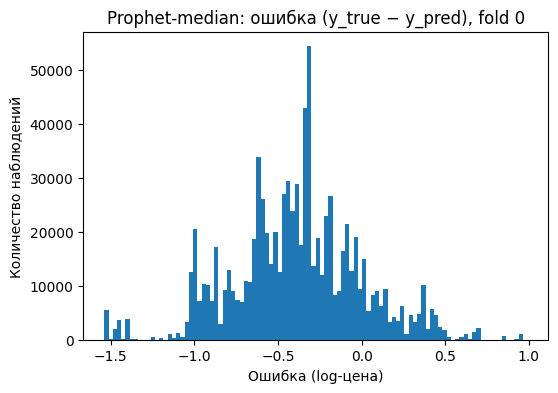

In [8]:
plt.figure(figsize=(6,4))
plt.hist(y_true - y_pred, bins=100)
plt.title("Prophet-median: ошибка (y_true − y_pred), fold 0")
plt.xlabel("Ошибка (log-цена)")
plt.ylabel("Количество наблюдений")
plt.show()

* Prophet смог слегка снизить RMSE (≈ -0.2 %) — значит сезонные компоненты учтены, но запас для ML-/DL-моделей огромный.

* sMAPE почти не изменился → модель пока не умеет ловить крупные относительные перепады цены.

* Гистограмма ошибок смещена влево (много отрицательных) — Prophet систематически завышает прогноз цены (лог-цены) для части SKU.